# MNIST Digit Classification with Convolutional Neural Network (CNN)

**Discipline(s):** Computer Vision, Deep Learning

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

## 1. Import Statements

---



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

## 2. Data Preprocessing

---



The first step is to preprocess our data.

In [7]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)  # [60000, 28, 28]
print("Testing Images:", X_test.shape)    # [10000, 28, 28]
print("Training Labels:", y_train.shape)  # [60000]
print("Test Labels:", y_test.shape)       # [10000]

Training Images: torch.Size([60000, 28, 28])
Testing Images: torch.Size([10000, 28, 28])
Training Labels: torch.Size([60000])
Test Labels: torch.Size([10000])


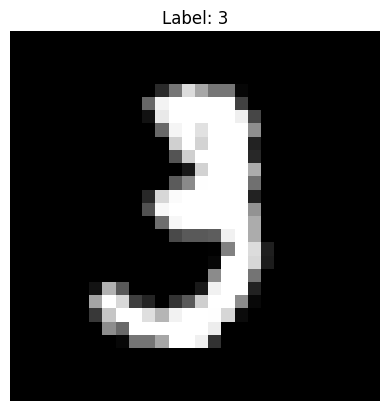

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_train[10], cmap='gray')
plt.title(f"Label: {y_train[10].item()}")
plt.axis('off')
plt.show()

## 3. Convolutional Neural Network (CNN)

---



### 3.1. Define the Model

We then have to define our convolutional neural network.

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
# 모델 준비
model = SimpleCNN().to(DEVICE)

Once our model is defined, we can compile it using the Adam optimizer and the categorical cross-entropy loss function.

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3.2. Train the Model

In [15]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [16]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [17]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.1350, Train Acc: 0.9583 | Test Loss: 0.0414, Test Acc: 0.9860
[Epoch 2] Train Loss: 0.0441, Train Acc: 0.9860 | Test Loss: 0.0304, Test Acc: 0.9902
[Epoch 3] Train Loss: 0.0285, Train Acc: 0.9912 | Test Loss: 0.0303, Test Acc: 0.9894
[Epoch 4] Train Loss: 0.0210, Train Acc: 0.9933 | Test Loss: 0.0320, Test Acc: 0.9899
[Epoch 5] Train Loss: 0.0158, Train Acc: 0.9949 | Test Loss: 0.0336, Test Acc: 0.9892
[Epoch 6] Train Loss: 0.0130, Train Acc: 0.9957 | Test Loss: 0.0245, Test Acc: 0.9916
[Epoch 7] Train Loss: 0.0107, Train Acc: 0.9963 | Test Loss: 0.0360, Test Acc: 0.9904
[Epoch 8] Train Loss: 0.0087, Train Acc: 0.9973 | Test Loss: 0.0336, Test Acc: 0.9914
[Epoch 9] Train Loss: 0.0079, Train Acc: 0.9976 | Test Loss: 0.0281, Test Acc: 0.9919
[Epoch 10] Train Loss: 0.0059, Train Acc: 0.9982 | Test Loss: 0.0333, Test Acc: 0.9911


### 3.3. 시각화

Finally, we can plot the curves.

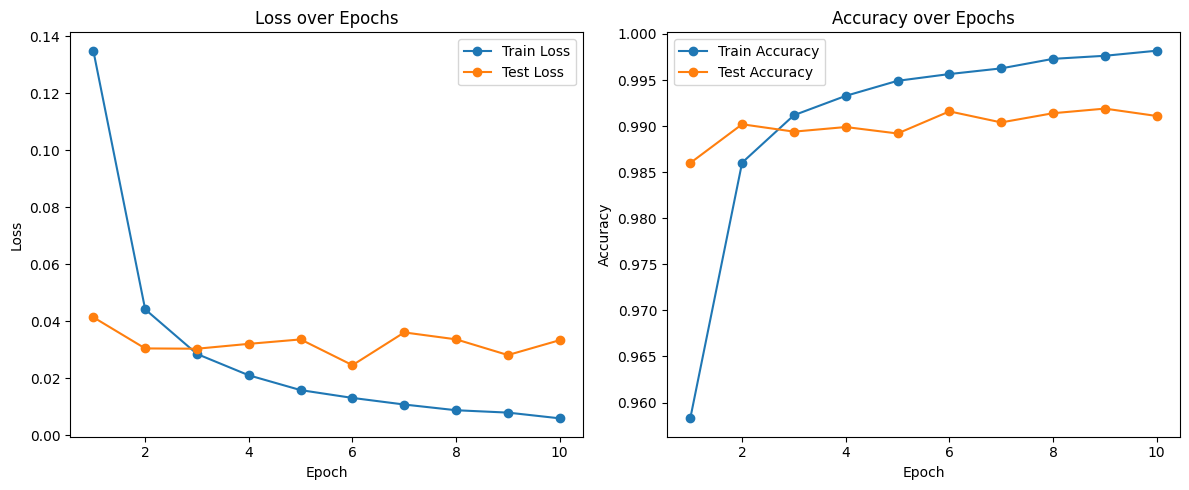

In [18]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [19]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

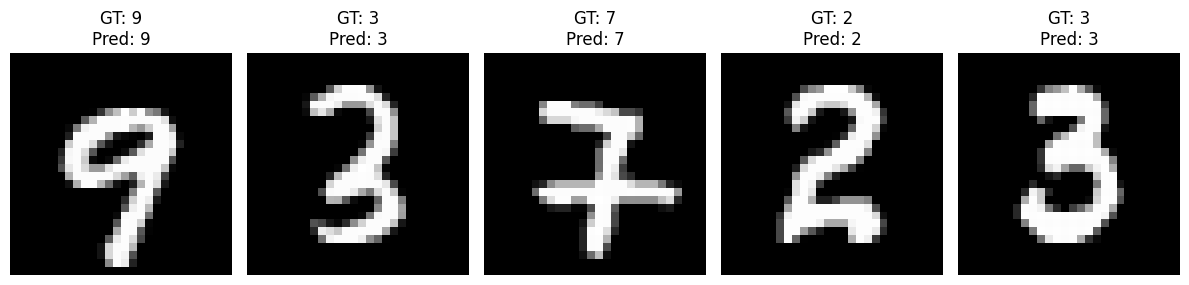

In [20]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [21]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.relu(out)

In [23]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → [B, 16, 14, 14]
        )

        self.layer1 = ResidualBlock(16, 32)  # → [B, 32, 14, 14]
        self.layer2 = ResidualBlock(32, 64)  # → [B, 64, 14, 14]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # → [B, 64, 1, 1]

        self.fc = nn.Linear(64, 10)  # 10-class output (e.g., MNIST)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # [B, 64]
        x = self.fc(x)
        return x


In [24]:
model = ResNetLike().to(DEVICE)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [26]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.2704, Train Acc: 0.9463 | Test Loss: 0.1748, Test Acc: 0.9450
[Epoch 2] Train Loss: 0.0522, Train Acc: 0.9859 | Test Loss: 0.0492, Test Acc: 0.9852
[Epoch 3] Train Loss: 0.0370, Train Acc: 0.9894 | Test Loss: 0.0439, Test Acc: 0.9851
[Epoch 4] Train Loss: 0.0323, Train Acc: 0.9903 | Test Loss: 0.0307, Test Acc: 0.9907
[Epoch 5] Train Loss: 0.0275, Train Acc: 0.9914 | Test Loss: 0.0331, Test Acc: 0.9894
[Epoch 6] Train Loss: 0.0229, Train Acc: 0.9934 | Test Loss: 0.0288, Test Acc: 0.9911
[Epoch 7] Train Loss: 0.0211, Train Acc: 0.9936 | Test Loss: 0.0271, Test Acc: 0.9907
[Epoch 8] Train Loss: 0.0194, Train Acc: 0.9942 | Test Loss: 0.0276, Test Acc: 0.9911
[Epoch 9] Train Loss: 0.0176, Train Acc: 0.9946 | Test Loss: 0.0246, Test Acc: 0.9919
[Epoch 10] Train Loss: 0.0166, Train Acc: 0.9945 | Test Loss: 0.0236, Test Acc: 0.9924


### 시각화

Finally, we can plot the curves.

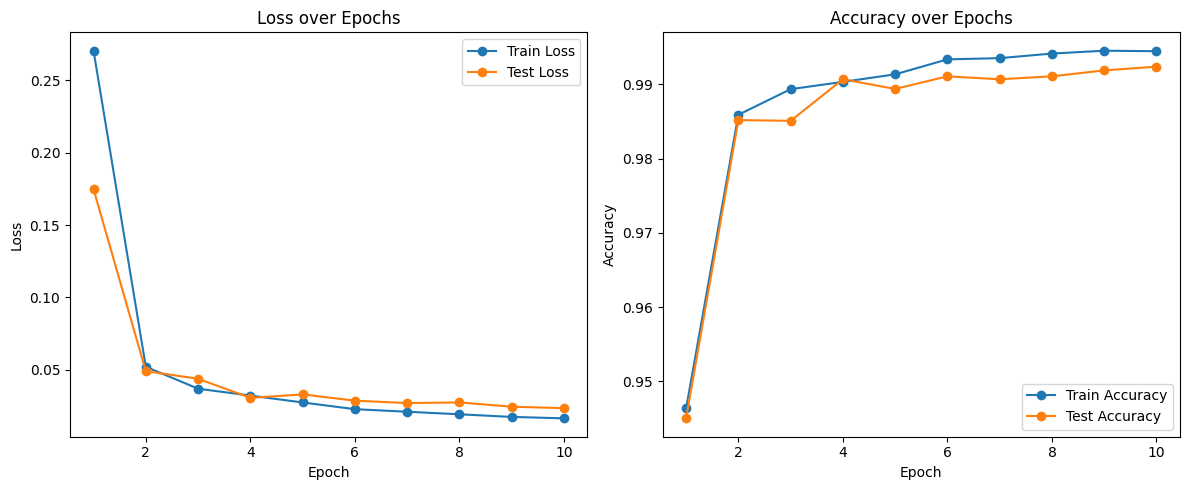

In [27]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [28]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

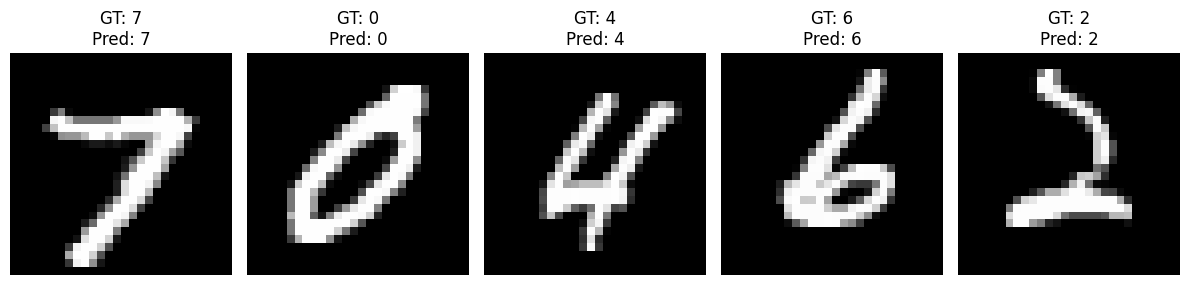

In [29]:
show_random_predictions(model, test_dataset, num_images=5)

# 다른 데이터셋으로도 진행해보기

In [30]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 3채널 정규화
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes  # ['airplane', 'automobile', ..., 'truck']


In [31]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # ❗ in_channels = 3
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer1 = ResidualBlock(16, 32)
        self.layer2 = ResidualBlock(32, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)  # CIFAR-10 → 10 classes

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetLike().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [33]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 1.4061, Train Acc: 0.4925 | Test Loss: 1.3268, Test Acc: 0.5141
[Epoch 2] Train Loss: 1.0624, Train Acc: 0.6216 | Test Loss: 1.0880, Test Acc: 0.6140
[Epoch 3] Train Loss: 0.9307, Train Acc: 0.6712 | Test Loss: 0.9722, Test Acc: 0.6540
[Epoch 4] Train Loss: 0.8439, Train Acc: 0.7020 | Test Loss: 0.9727, Test Acc: 0.6539
[Epoch 5] Train Loss: 0.7793, Train Acc: 0.7254 | Test Loss: 0.8431, Test Acc: 0.6982
[Epoch 6] Train Loss: 0.7219, Train Acc: 0.7468 | Test Loss: 0.8377, Test Acc: 0.7127
[Epoch 7] Train Loss: 0.6809, Train Acc: 0.7620 | Test Loss: 0.7936, Test Acc: 0.7119
[Epoch 8] Train Loss: 0.6468, Train Acc: 0.7745 | Test Loss: 0.7140, Test Acc: 0.7521
[Epoch 9] Train Loss: 0.6153, Train Acc: 0.7862 | Test Loss: 0.7473, Test Acc: 0.7420
[Epoch 10] Train Loss: 0.5922, Train Acc: 0.7947 | Test Loss: 0.7007, Test Acc: 0.7575


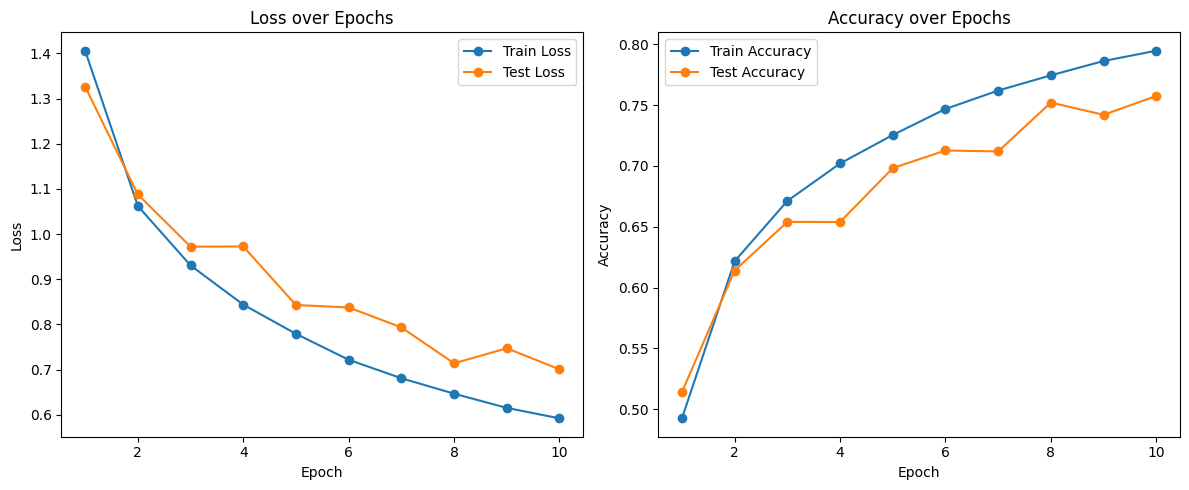

In [34]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = images[i].cpu().permute(1, 2, 0)  # (C, H, W) → (H, W, C)
        plt.imshow(img)
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6392157].


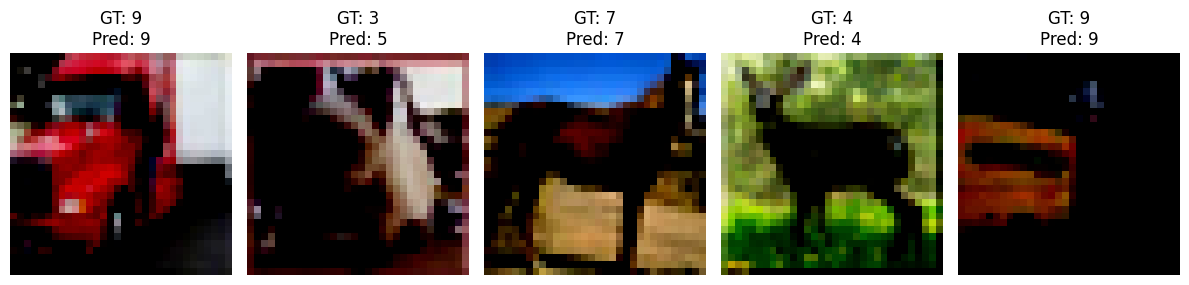

In [38]:
show_random_predictions(model, test_dataset, num_images=5)